# HyML - XML / (X)HTML generator for Hy

## Motivation

## Previous similar work

## Installation

My environment for the sake of clarity:

In [1]:
(import hy sys)
(print "Hy version: " hy.__version__)
(print "Python" sys.version)

Hy version:  0.12.1
Python 3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


## Import main macros

In [2]:
(require [hyml.macros [*]]
         [hyml.helpers [*]])
(import (hyml.macros (*)))
(import (hyml.helpers (indent)))

Then we are ready for the show!

## Almost all-in-one example

First I'd like to show an example that uses most features included in the HyML module. Then I will go thru all  presented features case by case.

In [3]:
; by default there is no indentation, thus for pretty print we use indent
(print (indent 
  ; specify parser macro (ML macros) that must be one of the following:
  ; xml, xhtml, xhtml5, html4, or html5 
  (xhtml5
  ; plain text content
  ; xml declaration below could also be done with a custom tag: (?xml :version "1.0" :encoding "UTF-8")
  "<?xml version=\"1.0\" encoding=\"UTF-8\"?>"
  ; more plain text content
  ; doctype could also be done with a custom tag: (!DOCTYPE "html")
  "<!DOCTYPE html>"
  ; define tag name as the first parameter
  ; define attributes by keywords
  (html :lang "en" :xmlns "http://www.w3.org/1999/xhtml"
    ; define nested tags and content by similar manner
    (head
      ; everything else except the first parameter and keywords are
      ; regarded as inner html content
      (title "Page title"))
    (body
      ; plain text content
      ; comments could also be done with a custom tag: (!-- "comments")
      "<!-- body starts here -->"
      ; short notation for div element and class attribute <div class=""/>
      ; note that - character in main-container will become to main_container due to Hy
      ; internal language construction
      (.main-container
         ; short notation for class attribute for specified element: <h1 class=""/>
         ; with multiple dot notation classes are concatenated with space
         (h1.main.header
           ; unquote macro with ~ to evaluate normal Hy code
           ; after unquoted expression rest of the code is continued to be parsed by ML macros again
           ~(.capitalize "page header"))
         ; short notation for id attribute for specified element: <ul id=""/>
         ; you should not use joined #main#sub similar to class notation, althought it is not prohibited,
         ; because id="main sub" is not a good id according to html attribute specifications
         (ul#main "List"
           ; unquote splice ~@ processes lists and concatenates results
           ; list-comp* is a slightly modified vesion of list-comp
           ; in list-comp* the list argument is the first and the expression is
           ; the second argument. in native list-comp those arguments are in reverse order
           ~@(list-comp* [[idx num] (enumerate (range 3))]
                         ; quote (`) a line and unquote variables and expressions to calculate
                         ; and set correct class for even and odd list items
                         `(li :class ~(if (even? idx) "even" "odd") ~num)))))))))

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html>
<html lang="en" xmlns="http://www.w3.org/1999/xhtml">
	<head>
		<title>Page title</title>
	</head>
	<body>
		<!-- body starts here -->
		<div class="main_container">
			<h1 class="main header">Page header</h1>
			<ul id="main">
				List
				<li class="even">0</li>
				<li class="odd">1</li>
				<li class="even">2</li>
			</ul>
		</div>
	</body>
</html>


## XML, HTML4, HTML5, XHTML, and XHTML5

At the moment HyML module contains `xml`, `html4`, `html5`, `xhtml`, and `xhtml5` macros (called as `ML` macros in short) to generate the (M)arkup (L)anguage code. `xml` is a generic generator which allows using any tag names and attributes. `html4` and `xhtml` macros allows to use only html4 specified tag names. Same applies to `html5` and `xhtml5`. Complete chart of the allowed elements are listed at the end of the document.

Tags can be created with or without attributes, as well as with or without content. For example:

In [4]:
(println
  (xml (node))
  (xml (node :attribute "")) ; force to use empty attribute
  (xml (node :attribute "value"))
  (xml (node :attribute "value" "")) ; force to use empty content
  (xml (node :attribute "value" "Content")))

<node/>
<node attribute=""/>
<node attribute="value"/>
<node attribute="value"></node>
<node attribute="value">Content</node>


However in `html4` and `html5` there are certain tags that cannot have endings so they will be rendered in correct form by the parser. "Forbidden" labeled tags are listed at the end of the document. One of them is for example the meta tag:

In [5]:
(html4 (meta :name "keywords" :content "HTML,CSS,XML,JavaScript"))

'<meta name=keywords content=HTML,CSS,XML,JavaScript>'

To see and compare the difference in xhtml, let macro print the same:

In [6]:
(xhtml (meta :name "keywords" :content "HTML,CSS,XML,JavaScript"))

'<meta name="keywords" content="HTML,CSS,XML,JavaScript"/>'

### Shorthand macro

`#㎖` (Square Ml) can be used as a shorthand [reader macro](http://docs.hylang.org/en/latest/language/readermacros.html) for generating xml/html/xhtml code:

In [7]:
#㎖(html
    (head (title "Page title"))
    (body (div "Page content" :class "container")))

'<html><head><title>Page title</title></head><body><div class="container">Page content</div></body></html>'

`#㎖` actually utilizes `xml` macro so same result can be achieved with the next, maybe more convenient and recommended notation:

In [8]:
(xml
  (html
    (head (title "Page title"))
    (body (div "Page content" :class "container"))))

'<html><head><title>Page title</title></head><body><div class="container">Page content</div></body></html>'

It is not possible to define other `ML` macro to be used with the `#㎖` shorthand reader macro. You could however define your own shorthands following next quidelines:

<code>(defreader {unicode-char} [code] (parse-{parser} code))</code>

`{unicode-char}` can be any [unicode char](https://unicode-table.com/en/) you want. `{parser}` must be one of the following available parsers: xml, xhtml, xhtml5, html4, or html5.

With `#㎖` shorthand you have to provide a single root node for generating code. Directry using `ML` macros makes it possible to generate multiple instances of code, and might be more informative notation style anyway:

In [9]:
(xml (p "Sentence 1") (p "Sentence 2") (p "Sentence 3"))

'<p>Sentence 1</p><p>Sentence 2</p><p>Sentence 3</p>'

Let us then render the code, not just printing it. This can be done via `html5>` macro imported earlier from helpers:

In [10]:
(html4> "Content is " (b king) !)

Renderers are available for all `ML` macros: `xml>`, `xhtml>`, `xhtml5>`, `html4>`, and `html5>`.

## Validation and minimizing

If validation of the html tag names is a concern, then one should use `html4`, `html5`, `xhtml`, and `xhtml5` macro family. In the example below if we try to use `time` element in `html4`, which is specifically available in `html5` only, we will get an `HyTMLError` exception:

In [11]:
;(try
; (html4 (time))
; (catch [e [HyTMLError]]))
;hytml.macros.HyTMLError: Tag 'time' not meeting html4 specs

Other features in `html4` and `html5` macros are attribute and tag minimizing. Under the [certain rules](https://html.spec.whatwg.org/multipage/syntax.html#optional-tags) start and end tags can be removed from the output. Also boolean attributes can be shortened. In `html4` and `html5` macros minimizing is a default feature that can't be bypassed. If you do not want to minimize code, you must use `xhtml` or `xhtml5` macro. Contrary in `xhtml` and `xhtml5` macros attribute and tag minimizing is NOT available. Instead all tags are strictly closed and attributes in `key="value"` format.

In [12]:
; valid html4 document
(html4 (title) (table (tr (td "Cell 1") (td "Cell 2") (td "Cell 3"))))

'<title/><table><tr><td>Cell 1<td>Cell 2<td>Cell 3</table>'

In [13]:
; in xhtml tags and attributes will be output in complete format
(xhtml (title) (table (tr (td "Cell 1") (td "Cell 2") (td "Cell 3"))))

'<title/><table><tr><td>Cell 1</td><td>Cell 2</td><td>Cell 3</td></tr></table>'

<blockquote>Note that above xhtml code is still not a valid xhtml document even tags and attributes are perfectly output. `ML` macros do no validate structure of the document just tag names. For validation one should use official [validator](https://validator.w3.org/) service and follow the html [specifications](https://w3c.github.io/html/) to create a valid document. `ML` macros can be used to guide on that process but more importantly it is meant to automatize the generation of the xml code while adding programming capabilities on it.</blockquote>

<blockquote>`xml` on the other hand doesn't give a dime of the used tag names. They can be anything, even processed names. Same applies to keywords, values, and contents. You should use more strict `xhtml`, `xhtml5`, `html4`, and `html5` macros to make sure that tag names are corresponding to HTML4 or HTML5 specifications.</blockquote>

In [14]:
; see how boolean attribute minimizing works
(html4 (input :disabled "disabled"))

'<input disabled>'

## Unquoting code

In all `ML` macros you can pass any code in it. See for example:

In [15]:
(xml (p "Sum: " (b (apply sum [[1 2 3 4]]))))

'<p>Sum: <b><apply>sum<[1, 2, 3, 4]/></apply></b></p>'

But you see, the result was not possibly what you expected. `ML` macros will interpret the first item of the _expression_ as a name of the tag. Thus _apply_ becomes a tag name. Until the next _expression_ everything else is interpreted either as a content or a keyword.

However using `~` (unquote) symbol, `ML` macro behaviour can be stopped for a moment:

In [16]:
(xml (p "Sum: " (b ~(apply sum [[1 2 3 4]])) !))

'<p>Sum: <b>10</b>!</p>'

So the following expression after `~` will be evaluated and then result is returned back to the original parser. And the rest of the code will be interpreted via macro. In this case it was just an exclamation mark.

<blockquote>Note that it is not mandatory to wrap strings with `""` if given input doesn't contain any spaces. You could also single quote simple non-spaced letter sequences. So `!` is same as `"!"` in this case.</blockquote>

Quoting and executing normal Hy code inside html gives almost unlimited possibility to use HyML as a templating engine. Of cource there is also a risk to evaluate code that breaks the code execution. Plus uncontrolled template engine code may be a security consern.

## Unquote splice

In addition to unquote, one can handle lists and iterators with `~@` (unquote-splice) symbol. This is particularly useful when a list of html elements needs to be passed to the parent element. Take for example this table head generation snippet:

In [17]:
(xhtml 
 (table (thead
   (tr ~@(list-comp
         `(th :class (if (even? ~i) "even" "odd") ~label " " ~i)
         [[i label] (enumerate (* ["col"] 3))])))))

'<table><thead><tr><th class="even">col 0</th><th class="odd">col 1</th><th class="even">col 2</th></tr></thead></table>'

[List comprehensions](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) notation might seem a little bit strange for some people. It takes a processing part (expression) as the first argument, and the actual list to be processed as the second argument. On a nested code this will move lists to be processed in first hand to the end of the notation. For example:

In [18]:
(xml> 
  ~@(list-comp `(ul (b "List")
      ~@(list-comp `(li item " " ~li)
          [li uls]))
    [uls [[1 2] [1 2]]]))

But there is another slighly modified macro to use in similar manner:

## `list-comp*`

Let's do again above example but this time with a dedicated `list-comp*` macro. Now the lists to be processed is passed as the first argument to the `list-comp*` macro and the expression for processing list items is the second argument. Yet the second argument itself contains a new list processing loop until final list item is to be processed. This is perhaps easier to follow for some people:

In [19]:
(xhtml
  ~@(list-comp* [uls [[1 2] [1 2]]]
    `(ul (b "List")
      ~@(list-comp* [li uls]
        `(li item " " ~li)))))

'<ul><b>List</b><li>item 1</li><li>item 2</li></ul><ul><b>List</b><li>item 1</li><li>item 2</li></ul>'

Of cource it is just a matter of the taste which one you like. `list-comp*` with `unquote-splice` symbol (`~@`) reminds us that it is possible to create any similar custom macros for the HyML processor. `~@` can be thought as a macro caller, not just unquoting and executing Hy code in a normal lisp mode.

Here is a more complex table generation example from the [remarkuple](http://nbviewer.jupyter.org/github/markomanninen/remarkuple3/blob/master/Remarkuple%203%20documentation.ipynb) Python module docs. One should notice how variables (`col`, `row`, and `cell`) are referenced by quoting them:

In [20]:
(html4>
  (table#data
    (caption "Data table")
    (colgroup
      (col :style "background-color:red")
      (col :style "background-color: green")
      (col :style "background-color: blue"))
    (thead
      (tr
        ~@(list-comp* [col ["Column 1" "Column 2" "Column 3"]]
          `(th ~col))))
    (tbody#tbody1
     ~@(list-comp* [row (range 1 3)]
       `(tr
         ~@(list-comp* [cell (range 3)]
           `(td  ~row "." ~cell)))))
    (tbody#tbody2
     ~@(list-comp* [row (range 1 3)]
       `(tr
         ~@(list-comp* [cell (range 3)]
           `(td  ~row "." ~cell)))))
    (tfoot 
      (tr
        (td :colspan "3" "Footer")))))

Column 1,Column 2,Column 3


### Address book table from CSV file

We should of course be able to use external source for the html. Let's try with a short csv file:

In [21]:
(xhtml> 
 (table.data
   (caption "Contacts")
   ~@(list-comp*
     [[idx row] (enumerate (.split (.read (open "data.csv" "r")) "\n"))]
     (if (pos? idx) 
         `(tbody
            ~@(list-comp* [item (.split row ",")]
              `(td ~item)))
         `(thead
            ~@(list-comp* [item (.split row ",")]
              `(th ~item)))))))

## Templates

It is possible to load code from an external file too. This feature has not been deeply implemented yet, but you get the feeling by the next example. Firt I'm just going to show external template file content:

In [22]:
(with [f (open "template.hy")] (print (f.read)))

(html :lang ~lang
  (head (title ~title))
  (body
  	(p ~body)))


Then I use `include` macro to read and process the content:

In [23]:
(defvar lang "en"
        title "Page title"
        body "Content")

(xhtml ~@(include "template.hy"))

'<html lang="en"><head><title>Page title</title></head><body><p>Content</p></body></html>'

All globally defined variables are available on `ML` macros likewise:

In [24]:
(xhtml ~lang ", " ~title ", " ~body)

'en, Page title, Content'

## HTML4 / 5 specifications

`xml` does not care about the markup specifications other than general tag and attribute notation. It is totally dummy about the naming conventions of the tags or their relation to each other or global structure of the markup document. It is all on the responsibility of the user to make it correct.

`html4` and `html5` macros will render tags as specified below. These macros will minimize code when possible. Using undefined tag will raise an error. Attributes are not validated however. One should use official [validator](http://validator.w3.org/) for a proper validation.

Below is the last example of using `ML` macros. It will print the first 5 rows of the HTML4/5 specifications.

Columns are:

- Tag name
- Tag title
- Forbidden (if there should be no content or end tag)
- Omit (forbidden plus omit short tag like `<col>`)
- HTML4 (is html4 compatible?)
- HTML5 (is html5 compatible?)

In [25]:
(xhtml>
  (table.data
    (caption "HTML Element Specifications")
    (thead
      (tr
        ~@(list-comp* [col ["Tag name" "Tag title" "Forbidden" "Omit" "HTML4" "HTML5"]]
          `(th ~col))))
    (tbody 
     ~@(list-comp* [[id row] (take 5 (.items (do (import (hyml.macros (specs))) specs)))]
       (do
        `(tr
          (td ~(.upper (get row :name)))
          (td ~(get row :name))
          (td ~(get row :forbidden))
          (td ~(get row :omit))
          (td ~(get row :html4) :class (if ~(get row :html4) "html4" ""))
          (td :class (if ~(get row :html5) "html5" ""))))))))

In [26]:
; lets import pandas dataframe for easy table view
(import [pandas])
; set max rows to 200 to prevent pruning displayed rows
(pandas.set_option "display.max_rows" 200)
; disable jupyter notebook autoscroll on the next cell

In [27]:
%javascript IPython.OutputArea.prototype._should_scroll = function(lines) {return false}

<IPython.core.display.Javascript object>

In [28]:
; show all specs
(pandas.DataFrame.transpose (pandas.DataFrame specs))

,﷐:forbidden,﷐:html4,﷐:html5,﷐:name,﷐:omit,﷐:title
﷐:a,False,True,True,a,False,Anchor
﷐:abbr,False,True,True,abbr,False,Abbreviation
﷐:acronym,False,True,False,acronym,False,Acronym
﷐:address,False,True,True,address,False,Address
﷐:applet,False,True,False,applet,False,Java applet
﷐:area,True,True,True,area,True,Image map region
﷐:article,False,False,True,article,False,Defines an article
﷐:aside,False,False,True,aside,False,Defines content aside from the page content
﷐:audio,False,False,True,audio,False,Defines sound content
﷐:b,False,True,True,b,False,Bold text



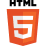

In [29]:
; include notebook custom styles
(IPython.display.HTML (.read (open "styles.css" "r")))

## The [MIT](http://choosealicense.com/licenses/mit/) License

Copyright (c) 2017 Marko Manninen